## Imports

In [ ]:
import sys
import sklearn
import numpy as np
import pandas as pd
import os
import matplotlib as plt

## Setup

In [2]:
# Python ≥3.5 is required
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
assert sklearn.__version__ >= "0.20"

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Get the Data

In [4]:
DATA_ROOT_PATH = os.path.join("datasets")

def load_data(data_path=DATA_ROOT_PATH):
    csv_path = os.path.join(data_path, "car_price_prediction.csv")
    return pd.read_csv(csv_path)

## Take a Quick Look at the Data Structure

In [5]:
car_data = load_data()
car_data.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.00000,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.00000,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.00000,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.00000,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.00000,Automatic,Front,04-May,Left wheel,Silver,4


In [6]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

## Check strange data

In [7]:
car_levy_non_numeric = car_data[~car_data["Levy"].str.isnumeric()]
print("Length: " + str(len(car_levy_non_numeric)))
car_levy_non_numeric.head() # some Levy attributes are missing or 0

Length: 5819


,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.00000,Variator,Front,04-May,Right-hand drive,Black,2
9,45756839,26657,-,LEXUS,RX 350,2007,Jeep,Yes,Petrol,3.5,128500 km,6.00000,Automatic,4x4,04-May,Left wheel,Silver,12
11,45814819,8781,-,FORD,Transit,1999,Microbus,No,CNG,4,0 km,8.00000,Manual,Rear,02-Mar,Left wheel,Blue,0
12,45815568,3000,-,OPEL,Vectra,1997,Goods wagon,No,CNG,1.6,350000 km,4.00000,Manual,Front,04-May,Left wheel,White,4
23,45814106,7840,-,FORD,Transit,2001,Microbus,No,Diesel,2.0 Turbo,230000 km,4.00000,Manual,Front,02-Mar,Left wheel,White,0


Comment:

"In the context of car prices, it might be an extra cost or fee associated with the purchase of a car. This could include government taxes, environmental fees, or other charges that are not part of the base price of the car."

In [8]:
car_data["Doors"].value_counts()

Doors
04-May    18332
02-Mar      777
>5          128
Name: count, dtype: int64

Comment from Dataset Creator:

"This field requires some data cleaning. 
The values must be 2-3, 4-5, >5. Probably creater might have put these values in Excel File and Excel would have converted them to Date Field & then might have saved as CSV Format."

## Data cleaning

In [9]:
def alter_doors(csv_data):
    csv_data["Doors"].replace(to_replace="02-Mar", value="2-3", inplace=True)
    csv_data["Doors"].replace(to_replace="04-May", value="4-5", inplace=True)


def alter_levy(csv_data):
    csv_data["Levy"].replace(to_replace="-", value=None, inplace=True)
    csv_data['Levy'] = pd.to_numeric(csv_data['Levy'], errors='coerce')


def alter_price(csv_data):
    idxs = csv_data.index[csv_data["Price"] > 250_000].tolist()
    print("Price to delete: " + str(len(idxs)))
    csv_data.drop(idxs, inplace=True)


def alter_mileage(csv_data):
    csv_data["Mileage"] = csv_data["Mileage"].str.replace(" km", "").astype(int)
    idxs = clean_data.index[clean_data["Mileage"] > 1_000_000].tolist()
    print("Mileage to delete: " + str(len(idxs)))
    csv_data.drop(idxs, inplace=True)


def alter_id(csv_data):
    csv_data.drop("ID", axis=1, inplace=True)


def alter_engine_volume(csv_data):
    engine_volume = csv_data["Engine volume"]
    engine_volume.replace(to_replace=",", value=".", inplace=True)
    engine_volume.replace(to_replace=" .*", value=None, regex=True, inplace=True)
    csv_data["Engine volume"] = engine_volume.astype(float)


def drop(csv_data):
    csv_data.drop(["Model", "Color", "Wheel"], axis=1, inplace=True)

In [10]:
clean_data = car_data.copy()

alter_doors(clean_data)
alter_price(clean_data)
alter_levy(clean_data) # leaves some Levy values NaN
alter_mileage(clean_data)
alter_id(clean_data)
alter_engine_volume(clean_data)
drop(clean_data)
clean_data.info()

Price to delete: 10
Mileage to delete: 74
<class 'pandas.core.frame.DataFrame'>
Index: 19153 entries, 0 to 19236
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             19153 non-null  int64  
 1   Levy              13405 non-null  float64
 2   Manufacturer      19153 non-null  object 
 3   Prod. year        19153 non-null  int64  
 4   Category          19153 non-null  object 
 5   Leather interior  19153 non-null  object 
 6   Fuel type         19153 non-null  object 
 7   Engine volume     17235 non-null  float64
 8   Mileage           19153 non-null  int32  
 9   Cylinders         19153 non-null  float64
 10  Gear box type     19153 non-null  object 
 11  Drive wheels      19153 non-null  object 
 12  Doors             19153 non-null  object 
 13  Airbags           19153 non-null  int64  
dtypes: float64(3), int32(1), int64(3), object(7)
memory usage: 2.1+ MB


In [11]:
clean_data.head()

,Price,Levy,Manufacturer,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Airbags
0,13328,1399.00000,LEXUS,2010,Jeep,Yes,Hybrid,3.50000,186005,6.00000,Automatic,4x4,4-5,12
1,16621,1018.00000,CHEVROLET,2011,Jeep,No,Petrol,3.00000,192000,6.00000,Tiptronic,4x4,4-5,8
2,8467,NaN,HONDA,2006,Hatchback,No,Petrol,1.30000,200000,4.00000,Variator,Front,4-5,2
3,3607,862.00000,FORD,2011,Jeep,Yes,Hybrid,2.50000,168966,4.00000,Automatic,4x4,4-5,0
4,11726,446.00000,HONDA,2014,Hatchback,Yes,Petrol,1.30000,91901,4.00000,Automatic,Front,4-5,4


## Take a Quick Look at the Data Structure

In [12]:
clean_data.describe()

,Price,Levy,Prod. year,Engine volume,Mileage,Cylinders,Airbags
count,19153.00000,13405.00000,19153.00000,17235.00000,19153.00000,19153.00000,19153.00000
mean,17050.36710,906.30362,2010.94758,2.31386,140049.31363,4.58236,6.58983
std,17598.17114,461.48385,5.62779,0.88850,102949.92061,1.19920,4.32007
min,1.00000,87.00000,1939.00000,0.00000,0.00000,1.00000,0.00000
25%,5331.00000,640.00000,2009.00000,1.80000,70000.00000,4.00000,4.00000
50%,13172.00000,781.00000,2012.00000,2.00000,125933.00000,4.00000,6.00000
75%,22248.00000,1058.00000,2015.00000,2.50000,188067.00000,4.00000,12.00000
max,228935.00000,11714.00000,2020.00000,20.00000,1000000.00000,16.00000,16.00000


array([[<Axes: title={'center': 'Price'}>,
        <Axes: title={'center': 'Levy'}>,
        <Axes: title={'center': 'Prod. year'}>],
       [<Axes: title={'center': 'Engine volume'}>,
        <Axes: title={'center': 'Mileage'}>,
        <Axes: title={'center': 'Cylinders'}>],
       [<Axes: title={'center': 'Airbags'}>, <Axes: >, <Axes: >]],
      dtype=object)

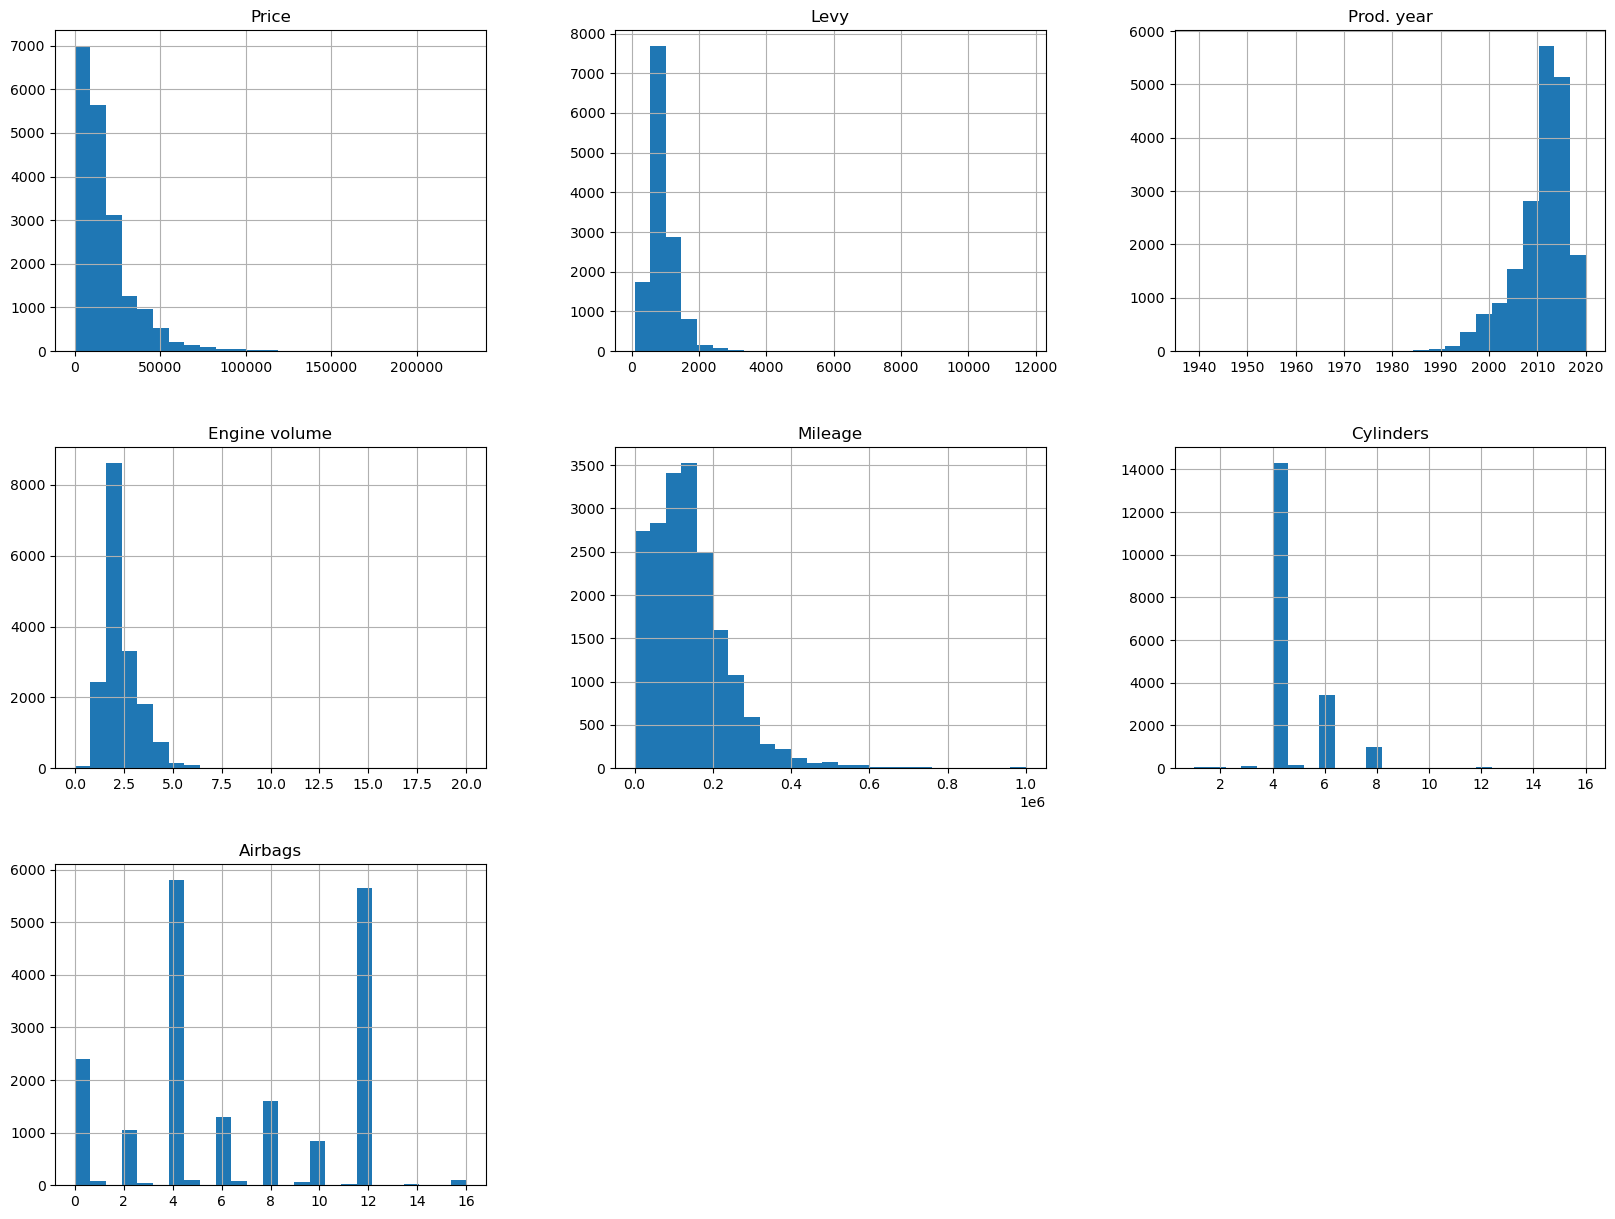

In [13]:
%matplotlib inline

clean_data.hist(bins=25, figsize=(20,15))

## Create a test set

<Axes: >

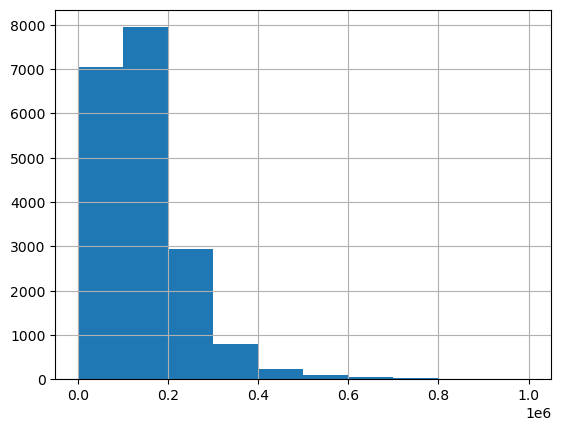

In [14]:
clean_data["Mileage"].hist()

In [15]:
clean_data["mileage_cat"] = pd.cut(clean_data["Mileage"],
                               bins=[-0.1, 40_000, 90_000, 140_000, 200_000, 300_000, np.inf],
                               labels=[1, 2, 3, 4, 5, 6])
print(len(clean_data["mileage_cat"]))
clean_data["mileage_cat"].value_counts()

19153


mileage_cat
3    4556
4    4312
2    3564
5    2833
1    2751
6    1137
Name: count, dtype: int64

<Axes: >

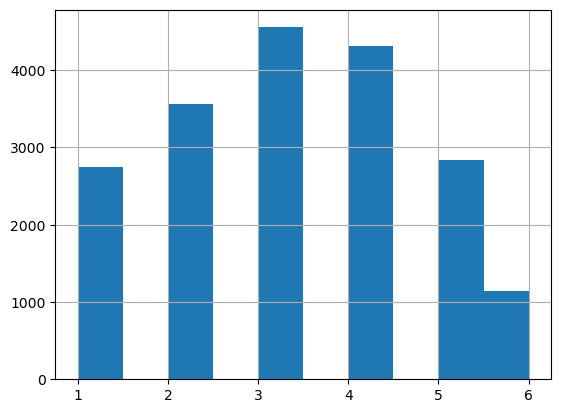

In [16]:
clean_data["mileage_cat"].hist()

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(clean_data, clean_data["mileage_cat"]):
    strat_train_set = clean_data.iloc[train_index]
    strat_test_set = clean_data.iloc[test_index]

In [18]:
def mileage_proportion(data):
    return data["mileage_cat"].value_counts() / len(data)


def compare_props(data, stratified_test, random_test):
    props = pd.DataFrame({
        "Overall": mileage_proportion(data),
        "Stratified": mileage_proportion(stratified_test),
        "Random": mileage_proportion(random_test),
    }).sort_index()

    props["Rand. %error"] = 100 * props["Random"] / props["Overall"] - 100
    props["Strat. %error"] = 100 * props["Stratified"] / props["Overall"] - 100

    return props

In [19]:
from sklearn.model_selection import train_test_split

rand_train_set, rand_test_set = train_test_split(clean_data, test_size=0.2, random_state=42)

In [20]:
compare_props(clean_data, strat_train_set, rand_train_set)

,Overall,Stratified,Random,Rand. %error,Strat. %error
mileage_cat,,,,,
1,0.14363,0.14365,0.14509,1.01136,0.01170
2,0.18608,0.18607,0.18692,0.45156,-0.00440
3,0.23787,0.23789,0.23770,-0.07421,0.00810
4,0.22513,0.22510,0.22282,-1.02942,-0.01478
5,0.14791,0.14789,0.14789,-0.01504,-0.01504
6,0.05936,0.05939,0.05959,0.37641,0.04659


In [21]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("mileage_cat", axis=1, inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14392\2643706102.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("mileage_cat", axis=1, inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_14392\2643706102.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("mileage_cat", axis=1, inplace=True)


## Discover and Visualize the Data to Gain Insights

In [22]:
car_data = strat_train_set.copy()

<Axes: xlabel='Prod. year', ylabel='Price'>

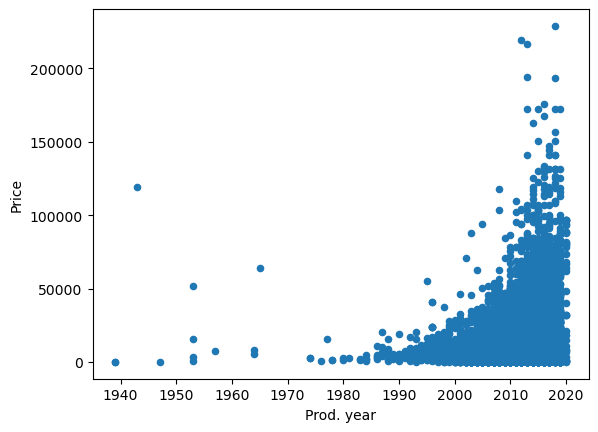

In [23]:
car_data.plot(kind="scatter", x="Prod. year", y="Price")

<Axes: xlabel='Mileage', ylabel='Price'>

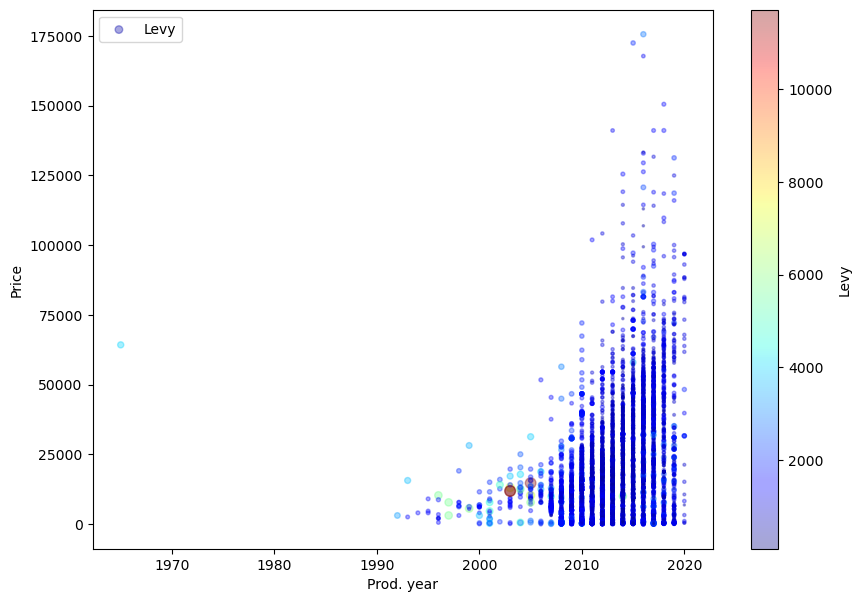

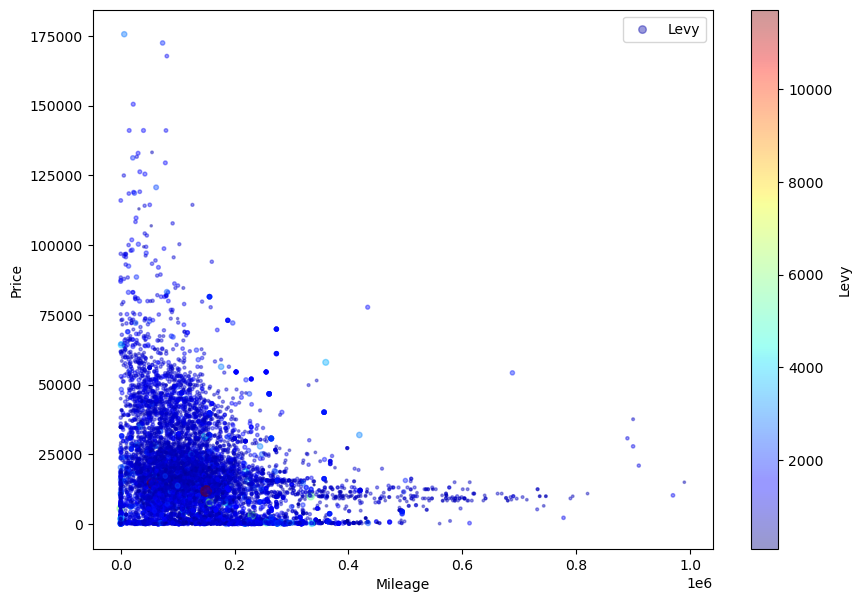

In [24]:
car_data.plot(kind="scatter", x="Prod. year", y="Price", alpha=0.35,
             s=car_data["Levy"] / 200, label="Levy", figsize=(10, 7),
             c="Levy", cmap=plt.colormaps["jet"], colorbar=True)


car_data.plot(kind="scatter", x="Mileage", y="Price", alpha=0.4,
             s=car_data["Levy"] / 200, label="Levy", figsize=(10, 7),
             c="Levy", cmap=plt.colormaps["jet"], colorbar=True)

Базуючись на графікаї можно зробити висновок, що:
- Більшість машин були випущені після 1990 року
- Більшість найдорожчих машин - нові машини
- Не факт, що найдорожча машина буде мати найбільший Levy
- Найдорожчі автомобілі мають невеликий Mileage
- Не факт, що найдешевша машина має найбільший Mileage

## Looking for Correlations

In [25]:
attrs = ["Price", "Levy", "Prod. year", "Mileage", "Cylinders", "Airbags"]
corr_matrix = car_data[attrs].corr()

In [26]:
corr_matrix["Price"].sort_values(ascending=False)

Price         1.00000
Prod. year    0.28727
Cylinders     0.08953
Levy          0.04279
Airbags      -0.03153
Mileage      -0.20718
Name: Price, dtype: float64

array([[<Axes: xlabel='Price', ylabel='Price'>,
        <Axes: xlabel='Prod. year', ylabel='Price'>,
        <Axes: xlabel='Mileage', ylabel='Price'>,
        <Axes: xlabel='Cylinders', ylabel='Price'>],
       [<Axes: xlabel='Price', ylabel='Prod. year'>,
        <Axes: xlabel='Prod. year', ylabel='Prod. year'>,
        <Axes: xlabel='Mileage', ylabel='Prod. year'>,
        <Axes: xlabel='Cylinders', ylabel='Prod. year'>],
       [<Axes: xlabel='Price', ylabel='Mileage'>,
        <Axes: xlabel='Prod. year', ylabel='Mileage'>,
        <Axes: xlabel='Mileage', ylabel='Mileage'>,
        <Axes: xlabel='Cylinders', ylabel='Mileage'>],
       [<Axes: xlabel='Price', ylabel='Cylinders'>,
        <Axes: xlabel='Prod. year', ylabel='Cylinders'>,
        <Axes: xlabel='Mileage', ylabel='Cylinders'>,
        <Axes: xlabel='Cylinders', ylabel='Cylinders'>]], dtype=object)

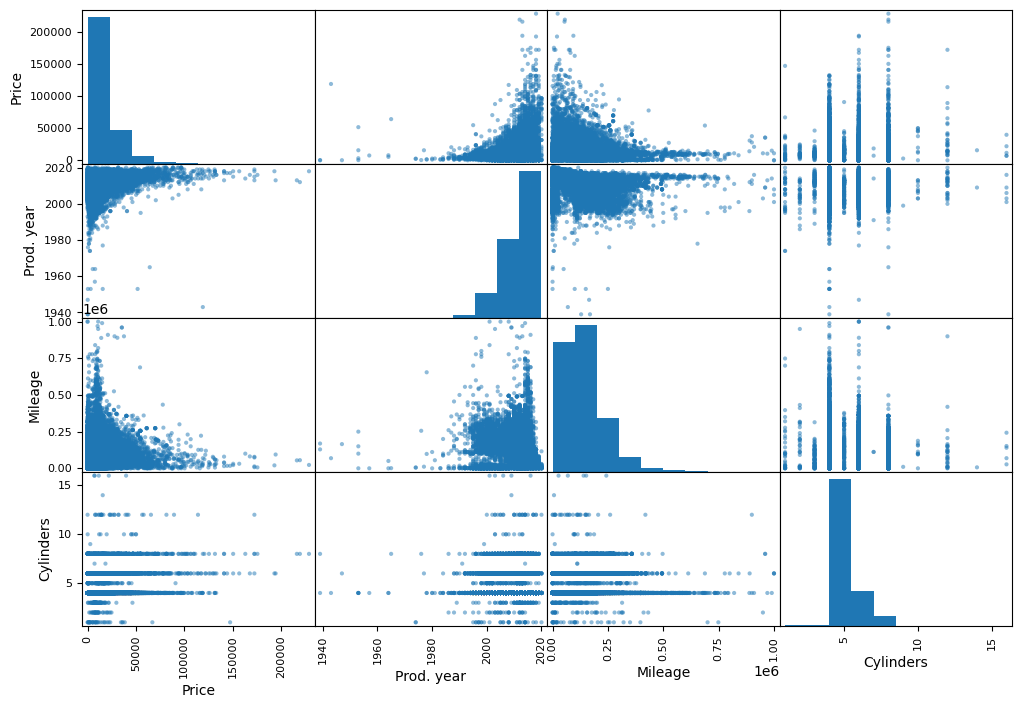

In [27]:
from pandas.plotting import scatter_matrix

attrs = ["Price", "Prod. year", "Mileage", "Cylinders"]
scatter_matrix(car_data[attrs], figsize=(12, 8))

Нічого цікавого не помітною В більшості параметрів кореляція не велика.

## Prepare the Data for Machine Learning Algorithms

In [28]:
car_data = strat_train_set.drop("Price", axis=1)
car_labels = strat_train_set["Price"].copy()

## Check possible categories values

In [29]:
car_data["Manufacturer"].value_counts()

Manufacturer
HYUNDAI          3023
TOYOTA           2925
MERCEDES-BENZ    1641
FORD              865
CHEVROLET         855
                 ... 
GREATWALL           1
TESLA               1
ASTON MARTIN        1
HAVAL               1
SAAB                1
Name: count, Length: 61, dtype: int64

In [30]:
# car_data["Model"].value_counts()

In [31]:
car_data["Category"].value_counts()

Category
Sedan          6914
Jeep           4388
Hatchback      2292
Minivan         501
Coupe           443
Universal       283
Microbus        245
Goods wagon     183
Pickup           41
Cabriolet        25
Limousine         7
Name: count, dtype: int64

In [32]:
car_data["Gear box type"].value_counts()

Gear box type
Automatic    10806
Tiptronic     2450
Manual        1461
Variator       605
Name: count, dtype: int64

In [33]:
car_data["Fuel type"].value_counts()

Fuel type
Petrol            8047
Diesel            3254
Hybrid            2876
LPG                714
CNG                362
Plug-in Hybrid      68
Hydrogen             1
Name: count, dtype: int64

In [34]:
car_data["Drive wheels"].value_counts()

Drive wheels
Front    10280
4x4       3221
Rear      1821
Name: count, dtype: int64

In [35]:
car_data["Doors"].value_counts()

Doors
4-5    14601
2-3      628
>5        93
Name: count, dtype: int64

In [36]:
# car_data["Wheel"].value_counts()

In [37]:
# car_data["Color"].value_counts()

In [38]:
car_data["Leather interior"].value_counts()

Leather interior
Yes    11122
No      4200
Name: count, dtype: int64

## Custom Transformers

In [39]:
car_data.head()

,Levy,Manufacturer,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Airbags
13216,528.00000,FORD,2014,Sedan,No,Petrol,NaN,152000,4.00000,Manual,Front,4-5,6
18756,NaN,BMW,2009,Sedan,Yes,Petrol,3.00000,170000,6.00000,Tiptronic,Rear,4-5,10
1098,NaN,MERCEDES-BENZ,1998,Sedan,Yes,CNG,2.30000,200000,4.00000,Automatic,Rear,4-5,4
7419,1275.00000,HYUNDAI,2019,Sedan,Yes,Petrol,2.40000,22832,4.00000,Automatic,4x4,4-5,12
10107,831.00000,SSANGYONG,2017,Jeep,Yes,Diesel,1.60000,42891,4.00000,Automatic,Front,4-5,4


In [40]:
from sklearn.base import BaseEstimator, TransformerMixin

def get_delete_columns():
    return ["Model", "Color", "Wheel"]


def get_delete_idxs(col_names):
    return [car_data.columns.get_loc(c) for c in col_names] # get the column indices


class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.columns = get_delete_idxs(get_delete_columns())

    
    def fit(self, X, y=None):
        return self


    def transform(self, X):
        if not self.columns:
            return X

        print(self.columns)
        return np.delete(X, self.columns, axis=1)            

In [41]:
# deleted_attrs = DropColumns().transform(car_data.values)
# deleted_attrs = pd.DataFrame(deleted_attrs,
#                              columns=car_data.columns.drop(get_delete_columns()),
#                              index=car_data.index)
# deleted_attrs.head()

## Transformation Pipelines

In [42]:
# cat_attribs = ["Manufacturer", "Category", "Model", "Leather interior", "Fuel type", "Gear box type", "Drive wheels", "Doors", "Color", "Wheel"]
cat_attribs = ["Manufacturer", "Category", "Leather interior", "Fuel type", "Gear box type", "Drive wheels", "Doors"]

car_num = car_data.drop(cat_attribs, axis=1)
car_num.head()

,Levy,Prod. year,Engine volume,Mileage,Cylinders,Airbags
13216,528.00000,2014,NaN,152000,4.00000,6
18756,NaN,2009,3.00000,170000,6.00000,10
1098,NaN,1998,2.30000,200000,4.00000,4
7419,1275.00000,2019,2.40000,22832,4.00000,12
10107,831.00000,2017,1.60000,42891,4.00000,4


In [43]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

car_num_tr = num_pipeline.fit_transform(car_num)
car_num_tr

array([[-0.86126714,  0.5438373 , -0.32942505,  0.11747653, -0.48084735,
        -0.14052934],
       [-0.21941057, -0.34646284,  0.86552065,  0.29266192,  1.18187959,
         0.78657099],
       [-0.21941057, -2.30512314,  0.02905866,  0.58463756, -0.48084735,
        -0.6040795 ],
       ...,
       [ 1.3484446 , -0.16840281,  1.4629935 ,  0.26562497,  1.18187959,
         1.25012116],
       [-0.21941057, -1.05870295, -0.32942505,  0.91022934,  1.18187959,
        -0.14052934],
       [ 0.0596575 ,  0.89995736, -0.32942505, -0.17801255, -0.48084735,
        -0.6040795 ]])

In [44]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

all_attribs = list(car_data)
num_attribs = list(car_num)

col_names = get_delete_columns()

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(sparse=False), cat_attribs),
    ])

car_data_prepared = full_pipeline.fit_transform(car_data)
car_data_prepared

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[-0.86126714,  0.5438373 , -0.32942505, ...,  0.        ,
         1.        ,  0.        ],
       [-0.21941057, -0.34646284,  0.86552065, ...,  0.        ,
         1.        ,  0.        ],
       [-0.21941057, -2.30512314,  0.02905866, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 1.3484446 , -0.16840281,  1.4629935 , ...,  0.        ,
         1.        ,  0.        ],
       [-0.21941057, -1.05870295, -0.32942505, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.0596575 ,  0.89995736, -0.32942505, ...,  0.        ,
         1.        ,  0.        ]])

## Select and Train a Model

In [45]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(car_data_prepared, car_labels)

LinearRegression()

In [46]:
some_data = car_data.iloc[:5]
some_labels = car_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Actual: ", list(some_labels))
print("Predictions", list(lin_reg.predict(some_data_prepared)))

Actual:  [25089, 22894, 8154, 13799, 43576]
Predictions [18688.0, 20160.0, -2304.0, 22112.0, 37216.0]


In [47]:
from sklearn.metrics import mean_squared_error

car_predictions = lin_reg.predict(car_data_prepared)
lin_mse = mean_squared_error(car_labels, car_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

14319.800435237408

In [48]:
car_labels.describe()

count    15322.00000
mean     16964.39760
std      17472.44991
min          1.00000
25%       5331.00000
50%      13172.00000
75%      22063.00000
max     228935.00000
Name: Price, dtype: float64

In [49]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(car_data_prepared, car_labels)

DecisionTreeRegressor(random_state=42)

In [50]:
car_predictions = tree_reg.predict(car_data_prepared)
tree_mse = mean_squared_error(car_labels, car_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

1904.2281199009476

## Better Evaluation Using Cross-Validation

In [51]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, car_data_prepared, car_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [52]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [11492.91418795 11805.10148246 13661.40527776 12032.25232442
 11125.57445696 10583.49160551 10727.87172968 12651.81039251
 11203.34272874 11512.82685924]
Mean: 11679.659104524319
Standard deviation: 878.4378140790461


In [53]:
lin_scores = cross_val_score(lin_reg, car_data_prepared, car_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [1.39601493e+04 1.37536583e+04 4.81889658e+13 1.38257252e+04
 4.36324007e+12 1.88232657e+14 6.50162595e+12 1.39498093e+04
 1.47161880e+04 1.14252558e+13]
Mean: 25871174438346.71
Standard deviation: 55903826586355.11


In [54]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=30, random_state=42)
forest_reg.fit(car_data_prepared, car_labels)

RandomForestRegressor(n_estimators=30, random_state=42)

In [55]:
car_predictions = forest_reg.predict(car_data_prepared)
forest_mse = mean_squared_error(car_labels, car_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

3944.096065844796

In [56]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, car_data_prepared, car_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [ 9464.40205964  8193.15760135 11457.7112689   9458.88112607
  9051.00002578  8324.1898446   9172.20286366  9061.59323756
  9008.99212592  8969.95246866]
Mean: 9216.208262214277
Standard deviation: 845.2142927282749


## Fine-Tune Your Model

### Grid Search

In [57]:
from sklearn.model_selection import GridSearchCV

param_grid = [
{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, 
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(car_data_prepared, car_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [58]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [59]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

### Analyze the Best Models and Their Errors

In [60]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([8.22518792e-02, 1.70922237e-01, 6.91606573e-02, 1.52400788e-01,
       3.88399317e-02, 9.53738163e-02, 1.28827829e-04, 1.66907314e-06,
       1.00523439e-04, 2.76624081e-03, 6.34713143e-03, 7.32222072e-03,
       7.74536538e-05, 1.60353743e-04, 4.09398484e-03, 1.29186994e-04,
       4.57683308e-05, 7.05239469e-04, 5.59297841e-05, 5.13075979e-04,
       6.34211679e-04, 2.25385104e-04, 8.11299344e-03, 1.07994805e-04,
       5.56842149e-05, 2.03064856e-06, 1.72361623e-05, 4.37263104e-03,
       2.69870102e-04, 1.19179016e-02, 2.91666668e-04, 5.23006100e-06,
       3.44492090e-03, 2.49656027e-03, 2.34430264e-03, 4.77207458e-03,
       7.72652629e-03, 1.52933456e-04, 9.19917251e-05, 1.15335410e-03,
       1.30046354e-02, 2.47380854e-05, 3.36827202e-04, 1.53654634e-03,
       7.38918006e-06, 3.14462375e-03, 1.51820928e-03, 1.55199224e-04,
       5.64162453e-03, 1.39476248e-04, 2.69970734e-05, 8.53559754e-06,
       9.99361536e-06, 1.20078512e-05, 4.75350545e-06, 1.52873369e-04,
      

In [61]:
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.1709222373881186, 'Prod. year'),
 (0.15240078795174883, 'Mileage'),
 (0.09537381629941338, 'Airbags'),
 (0.08225187918006281, 'Levy'),
 (0.06916065725345101, 'Engine volume'),
 (0.03883993166934342, 'Cylinders'),
 (0.013004635438877098, 'MERCEDES-BENZ'),
 (0.011917901595391524, 'HYUNDAI'),
 (0.011694941125067361, 'TOYOTA'),
 (0.00811299343774271, 'FORD'),
 (0.007726526290150123, 'LEXUS'),
 (0.007322220717831023, 'BMW'),
 (0.006347131425128672, 'BENTLEY'),
 (0.005641624526861124, 'PORSCHE'),
 (0.004772074584036296, 'LAND ROVER'),
 (0.004372631040169066, 'HONDA'),
 (0.004093984840308203, 'CHEVROLET'),
 (0.003890444921693267, 'SSANGYONG'),
 (0.0034449208951666025, 'JAGUAR'),
 (0.0031446237544270313, 'NISSAN'),
 (0.0027662408080121608, 'AUDI'),
 (0.0024965602726179396, 'JEEP'),
 (0.002444670382719061, 'VOLKSWAGEN'),
 (0.002344302637508144, 'KIA'),
 (0.0020614612223167086, 'SUBARU'),
 (0.0015365463449262312, 'MITSUBISHI'),
 (0.00151820927621376, 'OPEL'),
 (0.0011533540964538383, 'MAZDA'

## Evaluate Your System on the Test Set

In [64]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("Price", axis=1)
y_test = strat_test_set["Price"].copy()


def to_remove():
    idxs = X_test.index[X_test["Manufacturer"].isin(['LANCIA', 'PONTIAC', 'SATURN'])]
    X_test.drop(idxs, inplace=True)
    y_test.drop(idxs, inplace=True)


to_remove()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [65]:
final_rmse

9397.84986862526